# Урок 2. Feed-forward neural network
# Домашнее задание

1. Добиться хорошего результата от модели, собранной на занятии (5 угаданныx картинок из 8 предложенных). Варианты изменений:
- изменение слоёв и их количества;
- изменение метода оптимизации;
- изменение процесса обучения;
- *преобразование данных transform

2. *Переписать данный туториал на PyTorch: https://www.tensorflow.org/tutorials/quickstart/beginner?hl=ru

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch import optim

In [2]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)


image, label = train_dataset[0]
print(image.size())
print(label)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
torch.Size([3, 32, 32])
6


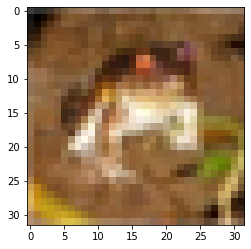

In [3]:
plt.imshow(image.permute(1, 2, 0).numpy());

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [5]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                          shuffle=False)

Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Составим класс для сети, с возможностью регулирования количества слоев и нейронов в них:

In [7]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=3):
        super().__init__()
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, (2 ** (n_layers - 2)) * hidden_dim))
        for i in range(1, n_layers - 1):
          self.layers.append(nn.Linear((2 ** (n_layers - i - 1)) * hidden_dim, (2 ** (n_layers - i - 2)) * hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        for layer in self.layers[:-1]:
          x = layer(x)
          x = F.leaky_relu(x)
        x = self.layers[-1](x)
        return x
    
    def predict(self, x):
        x = self.forward(x)
        x = F.softmax(x)
        return x

Составим функцию для обучения сети. Будем сразу валидироваться на тесте.

**Примечание по рассчету кросс-энтропии:**
Как я понял, встроенная функция расчитыват усредненный лосс на батче. Поэтому надо в конце эпохи делить аккумулятивный лосс на количество батчей, а не на количество картинок. Именно поэтому лоссы на тесте и на трейне на порядок не сходились в методичке.

In [8]:
def learn_net(net, criterion, optimizer, num_epochs):
  train_acc = []
  test_acc = []
  for epoch in range(num_epochs):
      running_loss = 0.0
      running_items = 0.0
      running_loss_test = 0.0
      running_items_test = 0.0
      running_right = 0.0
      running_right_test = 0.0

      net.train()
      for i, data in enumerate(train_loader):
          inputs, labels = data[0].to(device), data[1].to(device)
          # Обнуляем градиент
          optimizer.zero_grad()
          # Делаем предсказание
          outputs = net(inputs)
          # Рассчитываем лосс-функцию
          loss = criterion(outputs, labels)
          # Делаем шаг назад по лоссу
          loss.backward()
          # Делаем шаг нашего оптимайзера
          optimizer.step()

          # выводим статистику о процессе обучения
          running_loss += loss.item()
          running_items += len(labels)
          running_right += (labels == torch.max(outputs, 1)[1]).sum()

      running_right = running_right.item() 
      print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
            f'Loss_train: {running_loss / i:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}.', end=' ')
      acc = running_right / running_items
      train_acc.append(acc)
      # print(type(acc), acc, train_acc)
      running_loss, running_items, running_right = 0.0, 0.0, 0.0

      net.eval()
      for i, data in enumerate(test_loader):
          inputs, labels = data[0].to(device), data[1].to(device)
          # Делаем предсказание
          outputs = net(inputs)
          # Рассчитываем лосс-функцию
          loss = criterion(outputs, labels)

          running_loss_test += loss.item()
          running_items_test += len(labels)
          running_right_test += (labels == torch.max(outputs, 1)[1]).sum()

      running_right_test = running_right_test.item()
      print(f'Loss_test: {running_loss_test / i:.3f}. ' \
            f'Acc_test: {running_right_test / running_items_test:.3f}')
      test_acc.append(running_right_test / running_items_test)
      running_loss_test, running_items_test, running_right_test = 0.0, 0.0, 0.0

  print('Training is finished!')

  return train_acc, test_acc

In [9]:
print(f"Поддерживается ли CUDA : {torch.cuda.is_available()}")
print(f'Количество гпу девайсов: {torch.cuda.device_count()}')
print(f"Характеристики видеокарты : {torch.cuda.get_device_properties(0)}")
print(f"Удаляем всю незанятую память через torch.cuda.empty_cache()")

Поддерживается ли CUDA : True
Количество гпу девайсов: 1
Характеристики видеокарты : _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)
Удаляем всю незанятую память через torch.cuda.empty_cache()


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Обучим несколько сетей с глубиной 3, но с разным количеством нейронов (меняем параметр hidden_dim)

In [ ]:
train_metrics = []
test_metrics = []
for i in np.arange(50, 201, 50):
  net = Net(3*32*32, i, 10)
  net.to(device)
  net.train()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)
  train_acc, test_acc = learn_net(net, criterion, optimizer, 30)
  train_metrics.append(train_acc)
  test_metrics.append(test_acc)

Epoch [1/30]. Loss_train: 2.100. Acc: 0.247. Loss_test: 1.975. Acc_test: 0.265
Epoch [2/30]. Loss_train: 1.903. Acc: 0.318. Loss_test: 2.027. Acc_test: 0.289
Epoch [3/30]. Loss_train: 1.838. Acc: 0.345. Loss_test: 1.875. Acc_test: 0.342
Epoch [4/30]. Loss_train: 1.785. Acc: 0.365. Loss_test: 1.765. Acc_test: 0.363
Epoch [5/30]. Loss_train: 1.738. Acc: 0.382. Loss_test: 1.882. Acc_test: 0.324
Epoch [6/30]. Loss_train: 1.698. Acc: 0.395. Loss_test: 1.691. Acc_test: 0.398
Epoch [7/30]. Loss_train: 1.662. Acc: 0.410. Loss_test: 1.703. Acc_test: 0.399
Epoch [8/30]. Loss_train: 1.629. Acc: 0.421. Loss_test: 1.689. Acc_test: 0.395
Epoch [9/30]. Loss_train: 1.603. Acc: 0.433. Loss_test: 1.683. Acc_test: 0.389
Epoch [10/30]. Loss_train: 1.576. Acc: 0.440. Loss_test: 1.722. Acc_test: 0.378
Epoch [11/30]. Loss_train: 1.554. Acc: 0.450. Loss_test: 1.601. Acc_test: 0.432
Epoch [12/30]. Loss_train: 1.532. Acc: 0.456. Loss_test: 1.680. Acc_test: 0.391
Epoch [13/30]. Loss_train: 1.513. Acc: 0.465. Los

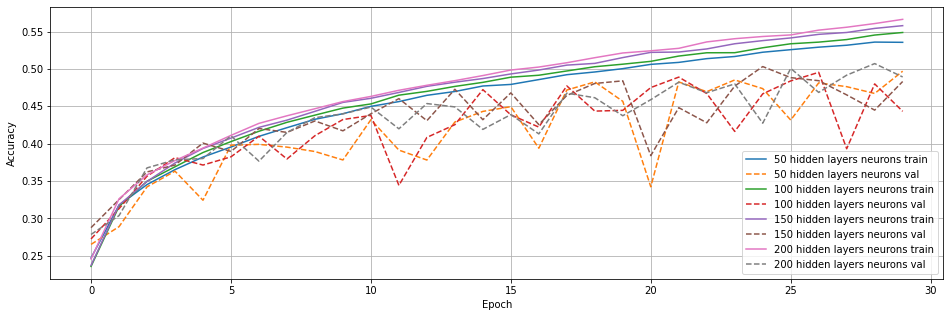

In [ ]:
plt.figure(figsize = (16,5))
for i in np.arange(4):
    plt.plot(train_metrics[i],'-',label = f'{(i + 1) * 50} hidden layers neurons' +' train')
    plt.plot(test_metrics[i],'--',label = f'{(i + 1) * 50} hidden layers neurons' + ' val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()  

Как видно, и на трейне и на тесте лучше всего проявляет себя модель с 200 нейронами на предпоследнем слое.

Далее будем менять количество слоев, но так, чтобы количество нейронов в первом слое оставалось неизменным. Поэтому, соответственно, параметр hidden_dim зависит от количества слоев.

In [11]:
train_metrics = []
test_metrics = []
for i in np.arange(3, 7, 1):
  hidden_dim = int(200 * (0.5 ** (i - 3)))
  net = Net(3*32*32, hidden_dim, 10, n_layers=i)
  net.to(device)
  net.train()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)
  train_acc, test_acc = learn_net(net, criterion, optimizer, 30)
  train_metrics.append(train_acc)
  test_metrics.append(test_acc)

Epoch [1/30]. Loss_train: 2.124. Acc: 0.242. Loss_test: 1.966. Acc_test: 0.292
Epoch [2/30]. Loss_train: 1.906. Acc: 0.323. Loss_test: 1.879. Acc_test: 0.320
Epoch [3/30]. Loss_train: 1.825. Acc: 0.353. Loss_test: 1.840. Acc_test: 0.346
Epoch [4/30]. Loss_train: 1.764. Acc: 0.375. Loss_test: 1.777. Acc_test: 0.359
Epoch [5/30]. Loss_train: 1.715. Acc: 0.395. Loss_test: 1.724. Acc_test: 0.388
Epoch [6/30]. Loss_train: 1.671. Acc: 0.412. Loss_test: 1.697. Acc_test: 0.393
Epoch [7/30]. Loss_train: 1.632. Acc: 0.424. Loss_test: 1.604. Acc_test: 0.430
Epoch [8/30]. Loss_train: 1.601. Acc: 0.434. Loss_test: 1.628. Acc_test: 0.421
Epoch [9/30]. Loss_train: 1.573. Acc: 0.445. Loss_test: 1.880. Acc_test: 0.343
Epoch [10/30]. Loss_train: 1.547. Acc: 0.453. Loss_test: 1.615. Acc_test: 0.415
Epoch [11/30]. Loss_train: 1.526. Acc: 0.461. Loss_test: 1.852. Acc_test: 0.353
Epoch [12/30]. Loss_train: 1.503. Acc: 0.470. Loss_test: 1.550. Acc_test: 0.446
Epoch [13/30]. Loss_train: 1.482. Acc: 0.477. Los

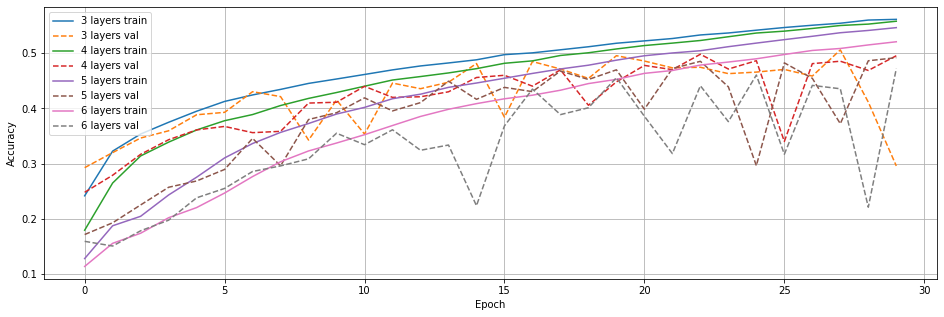

In [12]:
plt.figure(figsize = (16,5))
for i in np.arange(4):
    plt.plot(train_metrics[i],'-',label = f'{(i + 3)} layers' +' train')
    plt.plot(test_metrics[i],'--',label = f'{(i + 3)} layers' + ' val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show() 

Лучше всего проявляет себя модель с 3-мя слоями. Единственное, что на последних двух эпохах модель резко переобучилась и метрика на тесте улетела вниз.

Далее попробуем применить различные оптимизаторы:

In [23]:
train_metrics = []
test_metrics = []

for i in range(4):
  net = Net(3*32*32, 200, 10, n_layers=3)
  net.to(device)
  net.train()
  criterion = nn.CrossEntropyLoss()
  if i == 0:
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)
  elif i == 1:
    optimizer = optim.Adagrad(net.parameters(), lr=0.1)
  elif i == 2:
    optimizer = optim.RMSprop(net.parameters(), lr=0.1, alpha=0.99)
  else:
    optimizer = optim.Adam(net.parameters(), lr=0.1)
  train_acc, test_acc = learn_net(net, criterion, optimizer, 30)
  train_metrics.append(train_acc)
  test_metrics.append(test_acc)

Epoch [1/30]. Loss_train: 2.114. Acc: 0.236. Loss_test: 1.962. Acc_test: 0.292
Epoch [2/30]. Loss_train: 1.898. Acc: 0.327. Loss_test: 1.866. Acc_test: 0.337
Epoch [3/30]. Loss_train: 1.818. Acc: 0.356. Loss_test: 1.828. Acc_test: 0.344
Epoch [4/30]. Loss_train: 1.761. Acc: 0.378. Loss_test: 1.778. Acc_test: 0.373
Epoch [5/30]. Loss_train: 1.714. Acc: 0.394. Loss_test: 1.775. Acc_test: 0.360
Epoch [6/30]. Loss_train: 1.669. Acc: 0.408. Loss_test: 1.689. Acc_test: 0.395
Epoch [7/30]. Loss_train: 1.634. Acc: 0.422. Loss_test: 1.630. Acc_test: 0.416
Epoch [8/30]. Loss_train: 1.606. Acc: 0.431. Loss_test: 1.602. Acc_test: 0.428
Epoch [9/30]. Loss_train: 1.576. Acc: 0.443. Loss_test: 1.572. Acc_test: 0.438
Epoch [10/30]. Loss_train: 1.553. Acc: 0.452. Loss_test: 1.583. Acc_test: 0.444
Epoch [11/30]. Loss_train: 1.529. Acc: 0.460. Loss_test: 1.586. Acc_test: 0.433
Epoch [12/30]. Loss_train: 1.508. Acc: 0.467. Loss_test: 1.604. Acc_test: 0.427
Epoch [13/30]. Loss_train: 1.487. Acc: 0.476. Los

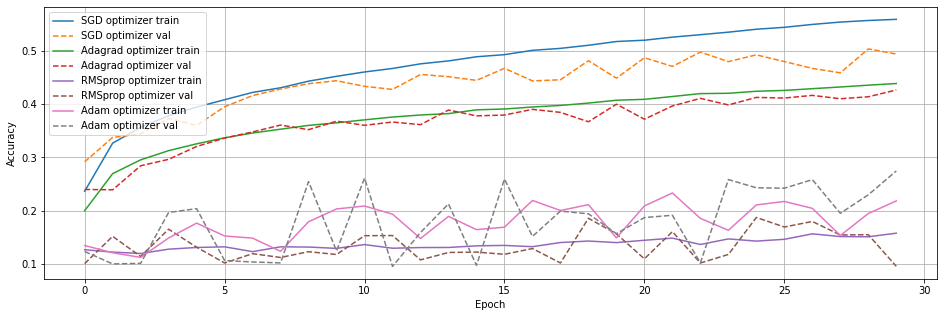

In [24]:
plt.figure(figsize = (16,5))
optimizers_func = ['SGD', 'Adagrad', 'RMSprop', 'Adam']
for i in np.arange(4):
    plt.plot(train_metrics[i],'-',label = f'{optimizers_func[i]} optimizer' +' train')
    plt.plot(test_metrics[i],'--',label = f'{optimizers_func[i]} optimizer' + ' val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show() 

Как ни странно, Adam, как и RMSprop,  показали плохие результаты. Лучше всего себя показала SGD

Теперь посмотрим, как меняется процесс обучения при разных размерах батчей:

In [30]:
train_metrics = []
test_metrics = []
for i in np.arange(4):
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=int(64 * 2 ** i), 
                                            shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=int(8 * 2 ** i),
                                            shuffle=False)
  net = Net(3*32*32, 200, 10, n_layers=3)
  net.to(device)
  net.train()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)
  train_acc, test_acc = learn_net(net, criterion, optimizer, 30)
  train_metrics.append(train_acc)
  test_metrics.append(test_acc)

Epoch [1/30]. Loss_train: 2.131. Acc: 0.228. Loss_test: 1.977. Acc_test: 0.296
Epoch [2/30]. Loss_train: 1.909. Acc: 0.325. Loss_test: 1.862. Acc_test: 0.341
Epoch [3/30]. Loss_train: 1.824. Acc: 0.356. Loss_test: 1.868. Acc_test: 0.329
Epoch [4/30]. Loss_train: 1.762. Acc: 0.378. Loss_test: 1.772. Acc_test: 0.368
Epoch [5/30]. Loss_train: 1.712. Acc: 0.394. Loss_test: 1.807. Acc_test: 0.355
Epoch [6/30]. Loss_train: 1.672. Acc: 0.409. Loss_test: 1.733. Acc_test: 0.387
Epoch [7/30]. Loss_train: 1.637. Acc: 0.420. Loss_test: 1.631. Acc_test: 0.420
Epoch [8/30]. Loss_train: 1.604. Acc: 0.432. Loss_test: 1.596. Acc_test: 0.432
Epoch [9/30]. Loss_train: 1.576. Acc: 0.445. Loss_test: 1.666. Acc_test: 0.407
Epoch [10/30]. Loss_train: 1.550. Acc: 0.454. Loss_test: 1.545. Acc_test: 0.451
Epoch [11/30]. Loss_train: 1.526. Acc: 0.461. Loss_test: 1.656. Acc_test: 0.417
Epoch [12/30]. Loss_train: 1.505. Acc: 0.468. Loss_test: 1.515. Acc_test: 0.470
Epoch [13/30]. Loss_train: 1.485. Acc: 0.474. Los

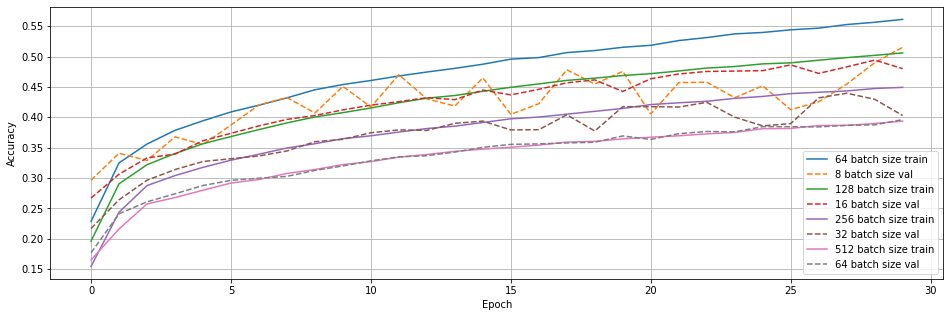

In [31]:
plt.figure(figsize = (16,5))
for i in np.arange(4):
    plt.plot(train_metrics[i],'-',label = f'{64 * 2 ** i} batch size' +' train')
    plt.plot(test_metrics[i],'--',label = f'{8 * 2 ** i} batch size' + ' val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show() 

По графику можно сделать следующие выводы:


*   Чем меньше батчи, тем нестабильнее ведет себя валидация на тесте
*   Обучение на батчах в 512 картинок выглядит очень стабильным, и кажется, что у такого обучения есть перспектива, но надо в разы больше эпох (около 90).
*   Для обучения на 30 эпохах лучшим вариантов выглядит батч в 128 картинов.





In [32]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=128, 
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16,
                                          shuffle=False)
net = Net(3*32*32, 200, 10, n_layers=3)
net.to(device)
net.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)
train_acc, test_acc = learn_net(net, criterion, optimizer, 30)


Epoch [1/30]. Loss_train: 2.227. Acc: 0.204. Loss_test: 2.116. Acc_test: 0.250
Epoch [2/30]. Loss_train: 2.035. Acc: 0.282. Loss_test: 1.971. Acc_test: 0.302
Epoch [3/30]. Loss_train: 1.936. Acc: 0.314. Loss_test: 1.899. Acc_test: 0.331
Epoch [4/30]. Loss_train: 1.883. Acc: 0.336. Loss_test: 1.866. Acc_test: 0.335
Epoch [5/30]. Loss_train: 1.841. Acc: 0.354. Loss_test: 1.816. Acc_test: 0.363
Epoch [6/30]. Loss_train: 1.804. Acc: 0.365. Loss_test: 1.789. Acc_test: 0.370
Epoch [7/30]. Loss_train: 1.770. Acc: 0.375. Loss_test: 1.746. Acc_test: 0.388
Epoch [8/30]. Loss_train: 1.741. Acc: 0.385. Loss_test: 1.728. Acc_test: 0.384
Epoch [9/30]. Loss_train: 1.713. Acc: 0.394. Loss_test: 1.711. Acc_test: 0.398
Epoch [10/30]. Loss_train: 1.688. Acc: 0.404. Loss_test: 1.688. Acc_test: 0.403
Epoch [11/30]. Loss_train: 1.664. Acc: 0.413. Loss_test: 1.651. Acc_test: 0.418
Epoch [12/30]. Loss_train: 1.643. Acc: 0.419. Loss_test: 1.636. Acc_test: 0.423
Epoch [13/30]. Loss_train: 1.624. Acc: 0.427. Los

In [33]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

GroundTruth:  cat ship ship plane frog frog car frog cat car plane truck dog horse truck ship
Predicted:  cat ship plane plane deer frog cat frog dog car ship truck car horse car ship


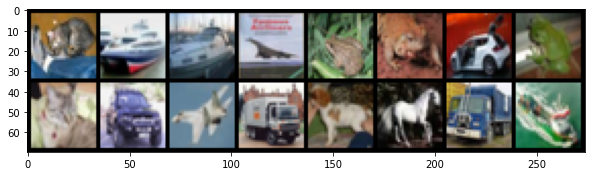

In [38]:
net.eval()
images = images.to(device)
labels = labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)
imgs = torchvision.utils.make_grid(images)
imgs = imgs.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))
print('Predicted: ', ' '.join(classes[predicted[j]] for j in range(len(labels))))

Если взять первые 8 картинок, то угаданы 5 картинок из 8 предложенных

In [39]:
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog' 'cat' 'car'
 'plane' 'truck' 'dog' 'horse' 'truck' 'ship']
['cat' 'ship' 'plane' 'plane' 'deer' 'frog' 'cat' 'frog' 'dog' 'car'
 'ship' 'truck' 'car' 'horse' 'car' 'ship']
Accuracy is 0.5625
